In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def f(x):
    return 3*x**2 - 4*x+ 5

In [6]:
f(3.0)

20.0

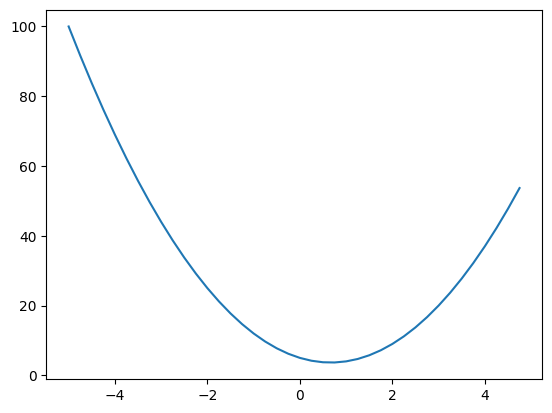

In [7]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)
plt.show()




In [8]:
h = 0.0001
x = (2/3)
(f(x+h) - f(x))/h

0.0002999999981767587

In [9]:
# lets get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [10]:
#inputs
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [11]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [12]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None 
        self._prev = set(_children)
        self._op = _op
        self.label = label    
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other -1)) * out.grad
        out._backward = _backward
        
        return out
        
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rmul__(self, other):
        return self * other

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()



In [13]:
a = Value(2.0)
a = 2*a ** 3
a.backward()
print(a.grad)

1.0


In [14]:
from graphviz import Digraph
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph (format='svg', graph_attr={'rankdir': 'LR'}) #LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
         # connect n1 to the op node of n2
         dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

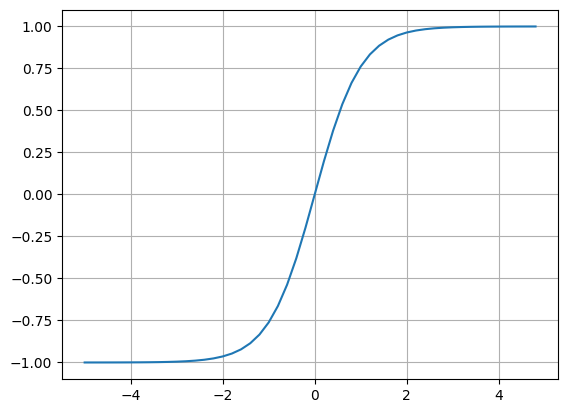

In [15]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [16]:
#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of nueron
b = Value(6.88, label='b')
x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x1*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'
o.backward()

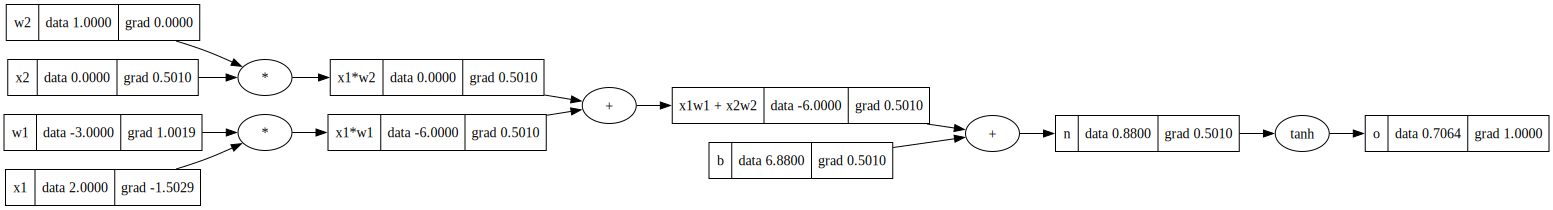

In [17]:
draw_dot(o)

In [18]:
#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of nueron
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x1*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
e = (2*n).exp()
o = (e-1) / (e+1)
o.label = 'o'
o.backward()

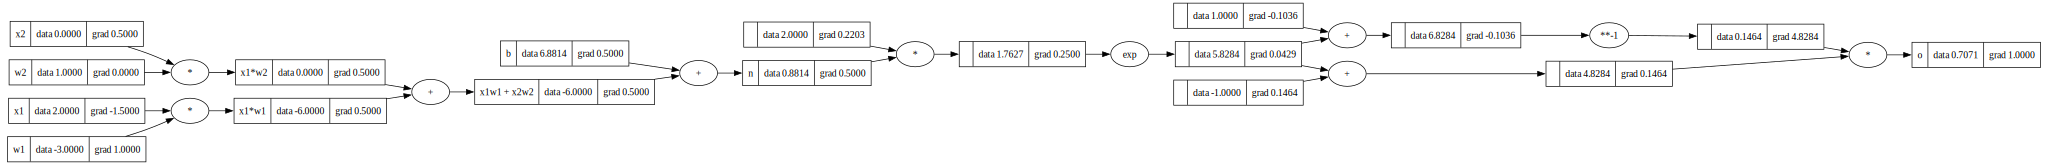

In [19]:
draw_dot(o)

In [20]:
import torch

In [21]:
x1 = torch.Tensor([2.0]).double()                   ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                   ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                  ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                   ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()     ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [26]:
x2.grad

tensor([0.5000], dtype=torch.float64)

In [23]:
import random

In [ ]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        #  w * x * b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]
        
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs 

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

    def __init__(self, nin, nouts):
        sz= [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [174]:
x = [2.0, 3.0, -1.0]
n = MLP (3, [4, 4, 1])
n(x)

Value(data=-0.5874191190542818)

In [175]:
len(n.parameters())

41

In [176]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.5874191190542818),
 Value(data=-0.5342297252870243),
 Value(data=-0.5964594393323683),
 Value(data=-0.4393906535847398)]

In [251]:
for k in range(10):

    # forward pass
    ypred = [n(x) for x in xs]
    #loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), start=Value(0))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)    


0 5.155260039848142e-05
1 5.1477305856108136e-05
2 5.140224729173107e-05
3 5.132742357520652e-05
4 5.12528335836609e-05
5 5.1178476201433257e-05
6 5.1104350320016245e-05
7 5.1030454837997904e-05
8 5.095678866101036e-05
9 5.0883350701662854e-05


In [252]:
ypred

[Value(data=0.9940396723374444),
 Value(data=-0.9999999998948988),
 Value(data=-0.999999999900676),
 Value(data=0.99608109136919)]

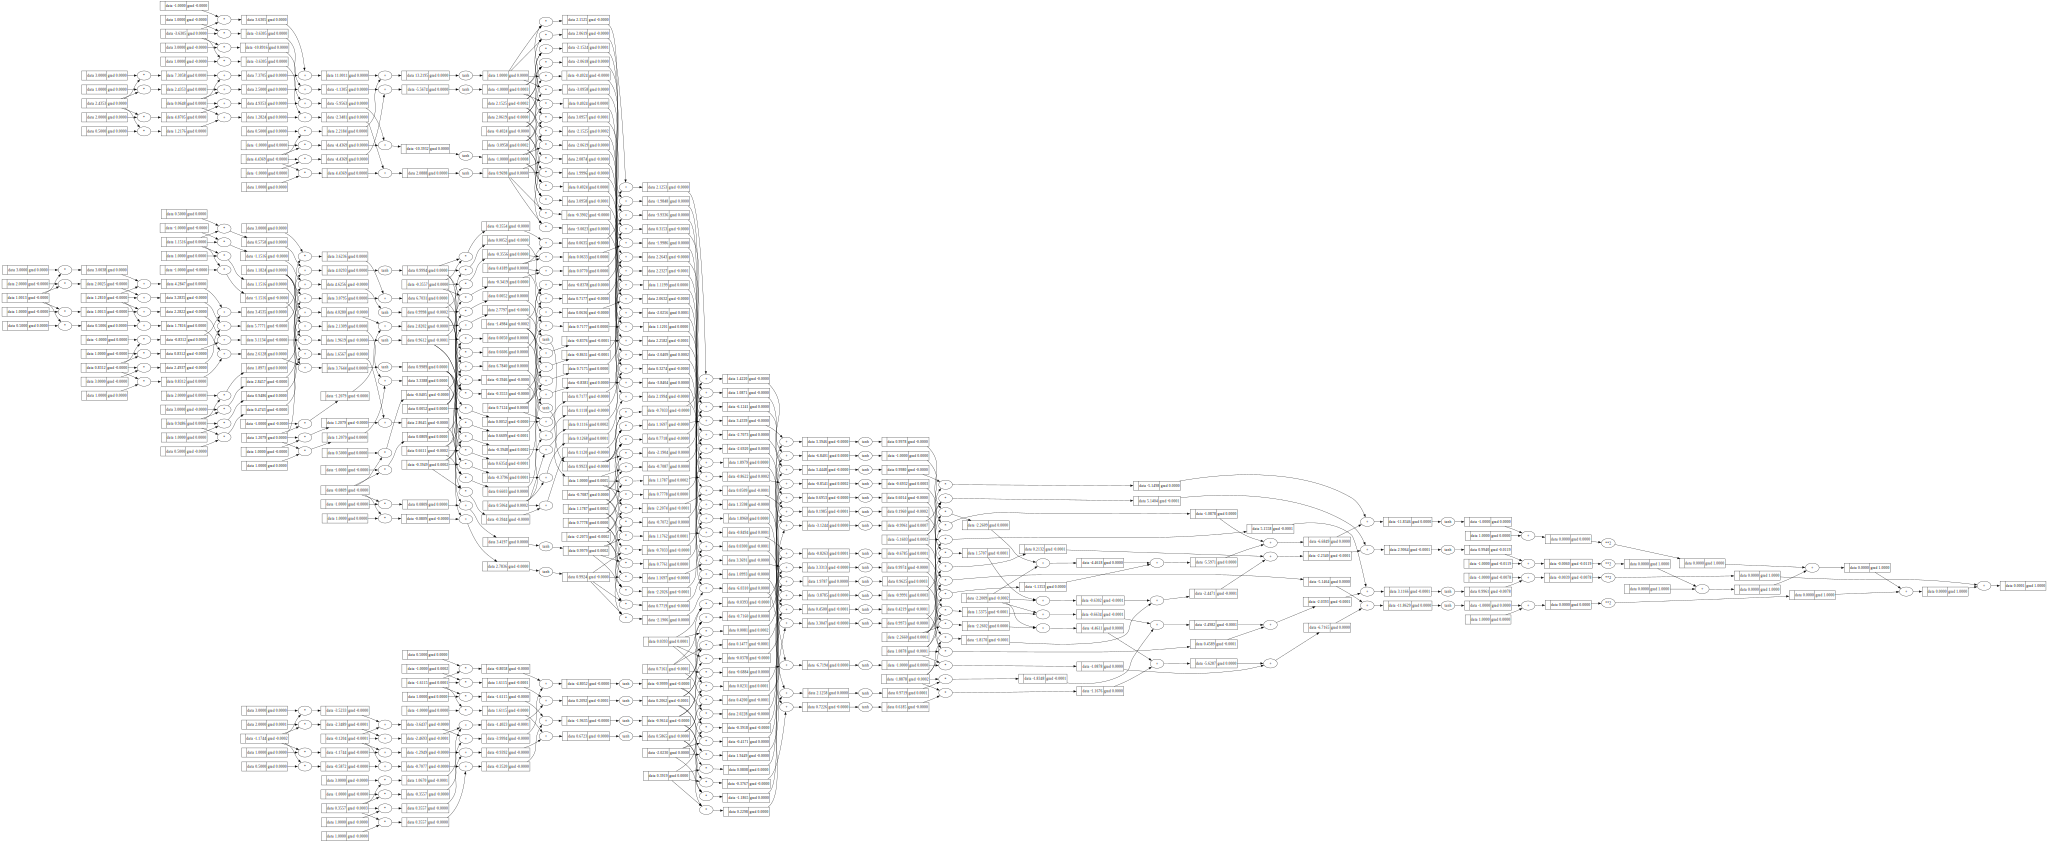

In [253]:
draw_dot(loss)

In [74]:
combined = zip(ys, ypred)
print(list(combined))

[(1.0, Value(data=0.8305658861604271)), (-1.0, Value(data=-0.02102937289696447)), (-1.0, Value(data=0.6512567704895503)), (1.0, Value(data=0.815782195266384))]


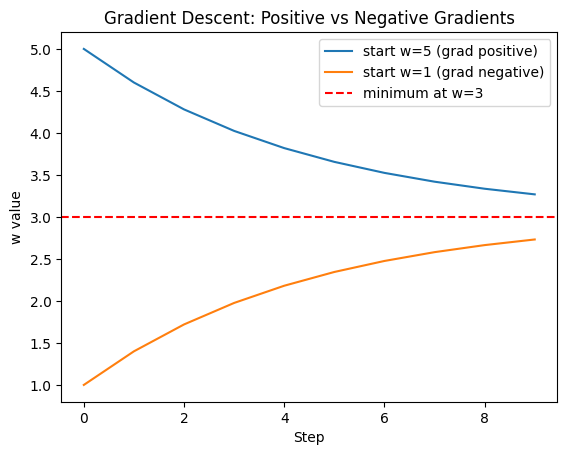

In [25]:
import torch
import matplotlib.pyplot as plt

def run_gradient_descent(start_w, steps=10, lr=0.1):
    w = torch.tensor([start_w], requires_grad=True)
    ws, losses, grads = [], [], []
    
    for step in range(steps):
        L = (w - 3)**2
        L.backward()
        
        ws.append(w.item())
        losses.append(L.item())
        grads.append(w.grad.item())
        
        with torch.no_grad():
            w -= lr * w.grad
        w.grad.zero_()
    
    return ws, losses, grads

# Run two experiments
ws_pos, losses_pos, grads_pos = run_gradient_descent(5.0)
ws_neg, losses_neg, grads_neg = run_gradient_descent(1.0)

# Plot parameter updates
plt.plot(ws_pos, label="start w=5 (grad positive)")
plt.plot(ws_neg, label="start w=1 (grad negative)")
plt.axhline(3, color="red", linestyle="--", label="minimum at w=3")
plt.xlabel("Step")
plt.ylabel("w value")
plt.legend()
plt.title("Gradient Descent: Positive vs Negative Gradients")
plt.show()


In [254]:
np.random.seed(42)
x = np.linspace(0, 10, 20)
y = 2.0 * x + 1.0 + np.random.randn(20) * 2.0

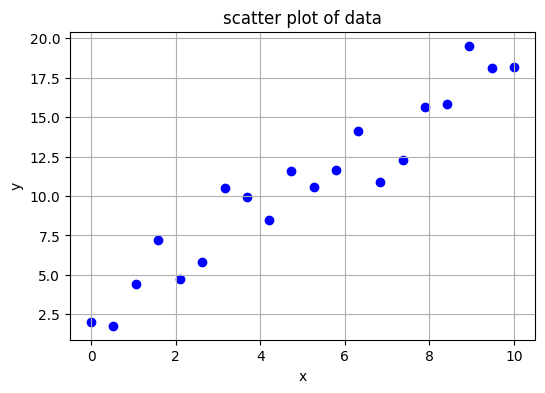

In [259]:
plt.figure(figsize=(6, 4))
plt.scatter(x, y, color='blue')
plt.title("scatter plot of data")
plt.xlabel('x')
plt.ylabel('y')
#plt.legend()
plt.grid(True)
plt.show()

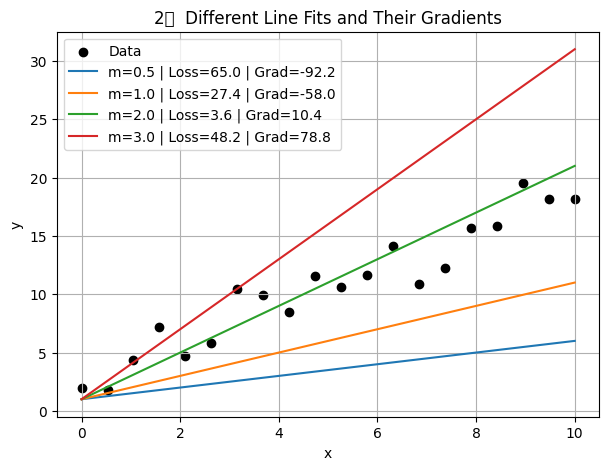

In [ ]:
slopes = [0.5, 1.0, 2.0, 3.0]
intercept = 1.0

def mse_loss_and_grad(m):
    y_pred = m * x + intercept
    error = y_pred - y
    loss = np.mean(error ** 2)
    grad = 2 * np.mean(error * x)  # derivative of MSE wrt m
    return loss, grad

plt.figure(figsize=(7,5))
plt.scatter(x, y, color='black', label='Data')

for m in slopes:
    y_pred = m * x + intercept
    loss, grad = mse_loss_and_grad(m)
    plt.plot(x, y_pred, label=f"m={m:.1f} | Loss={loss:.1f} | Grad={grad:.1f}")

plt.title("2️⃣  Different Line Fits and Their Gradients")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


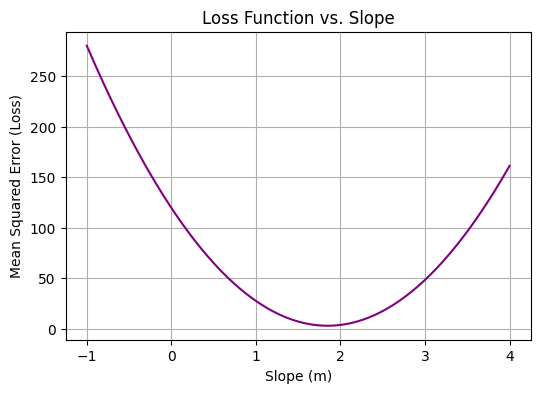

In [263]:
# Step 4: Compute loss (Mean Squared Error) for a range of slopes
m_values = np.linspace(-1, 4, 200)
loss_values = []
for m in m_values:
    y_pred = m*x + intercept
    loss = np.mean((y_pred - y)**2)
    loss_values.append(loss)

plt.figure(figsize=(6,4))
plt.plot(m_values, loss_values, color='purple')
plt.title("Loss Function vs. Slope")
plt.xlabel("Slope (m)")
plt.ylabel("Mean Squared Error (Loss)")
plt.grid(True)
plt.show()